# Utiltities

In [11]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
MAIN_PATH = "../data"

In [12]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 44.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [13]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from time import time

import spacy


NUMBER_OF_TOPICS = 9 # <-------- NUMBER OF TOPICS defined previously

STOP_WORDS = list(set(ENGLISH_STOP_WORDS).union(
    ['mml', 'math', 'inline', 'tex', 'mi', 'italic', 'latex', 'graphic', 'xlink', 'et', 'al',
     'gif', 'href', 'mo', 'mn', 'mrow',]
))

nlp = spacy.load('en_core_web_md')

def lemmatize(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if len(token.lemma_) > 2]

def run_lda(abstracts: np.ndarray):
    model = make_pipeline(
        CountVectorizer(max_df=0.95, min_df=2, max_features=1000, tokenizer=lemmatize, stop_words=STOP_WORDS),
        LatentDirichletAllocation(n_components=NUMBER_OF_TOPICS, max_iter=10, learning_method='online', n_jobs=20, random_state=42)
    )
    X = model.fit_transform(abstracts)
    return model, X

def plot_top_words(model, feature_names, n_top_words, title, names):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, (topic, name) in enumerate(zip(model.components_, names)):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"{name}", fontdict={"fontsize": 25})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    
    fig.delaxes(axes[-1])
    plt.subplots_adjust(top=.85, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(f"../figures/lda-topics.pdf", bbox_inches="tight")
    plt.show()

# Run lda

In [14]:
venue_areas = ['ai', 'information', 'mining', 'hci', 'linguistic', 'vision']

abstracts = pl.concat([
    pl.read_parquet(f'{MAIN_PATH}/abstracts_filtered.parquet'),
    pl.read_parquet(f'{MAIN_PATH}/top10-abstracts.parquet'),
]).unique('corpusid')

corpus = (
    pl.read_parquet(f'{MAIN_PATH}/corpus-240306.parquet')
    .filter(~pl.col('title').str.contains('(survey|benchmark|review|tutorial)'))
)

## Figure 8

In [ ]:
do_lda = False # <--- If False it reads from saved data, if True ~ 100min

topics = [
    'Algorithmic optimization\nin learning',
    'Language resources',
    'Information retrieval\n& search',
    'Computer vision',
    'Human-centered\ninformation systems',
    'Feature engineering',
    'Experiment design',
    'Temporal data\nmodelling',
    'Deep learning',
]


if do_lda:
    print("Reading input files")
    abs_df = abstracts.join(
        corpus.filter(pl.col('venue_area').is_in(venue_areas)).unique('corpusid'),
        on='corpusid',
        validate='1:1'
    ).to_pandas()

    print("Running LDA ..")
    start_time = time()
    model, X = run_lda(abs_df['abstract'].values)
    elapsed_time = time() - start_time
    print(f"Finished running LDA in {elapsed_time/60:.2f} mins")
    tf_feature_names = model[0].get_feature_names_out()
    
    
    ########## Plot
    plot_top_words(model[1], tf_feature_names, n_top_words=20, title="Topics in LDA model", names=topics)

    joblib.dump(model, f'{MAIN_PATH}/lda_model.joblib')  # Save the fitted LDA model
    abs_df['topic_id'] = X.argmax(axis=1)
    abs_df.to_parquet(f'{MAIN_PATH}/lda.parquet')

else:
    abs_df = pd.read_parquet(f'{MAIN_PATH}/lda.parquet')
    model = joblib.load(f'{MAIN_PATH}/lda_model.joblib')

Reading input files
Running LDA ..


/home/fcinus/miniconda3/envs/csimpact/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/fcinus/miniconda3/envs/csimpact/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn(


In [ ]:
topics = [
    'Information retrieval',
    'Data-centric AI',
    'Human-centered\ninformation systems',
    'Algorithmic optimization\nin learning',
    'Graph-based learning',
    'Computational efficiency\nalgorithms',
    'Computer vision',
    'State-of-the-art\nNLP models',
    'Language resources',
]

tf_feature_names = model[0].get_feature_names_out()

plot_top_words(model[1], tf_feature_names, n_top_words=20, title="Topics in LDA model", names=topics)

TypeError: 'LatentDirichletAllocation' object is not subscriptable

In [40]:
abs_df['is_innovation_success'] = abs_df['year_min_innovation'].notnull()
abs_df['is_development_success'] = abs_df['year_min_development'].notnull()

# Time series plot

In [46]:
GROUPS = [
    [
    'Graph-based learning',
    'State-of-the-art\nNLP models',
    'Data-centric AI',
    ],
    [
    'Algorithmic optimization\nin learning',
    'Language resources',
    'Information retrieval',
    ],
    [
    'Computational efficiency\nalgorithms',
    'Computer vision',
    'Human-centered\ninformation systems',
    ]
]

# Assuming GROUPS is a list of lists, where each sublist contains topics of a group.
GROUP_COLORS = {
    "group0": "Greens",
    "group1": "Reds",
    "group2": "Blues"
}

group_palettes = {}
group_linestyles = {}
for idx, group in enumerate(GROUPS):
    group_name = "group" + str(idx)
    group_palettes[group_name] = sns.color_palette(GROUP_COLORS[group_name], len(group))
    group_linestyles[group_name] = ["--", "-.", "-"]

## Figure 4 and 9

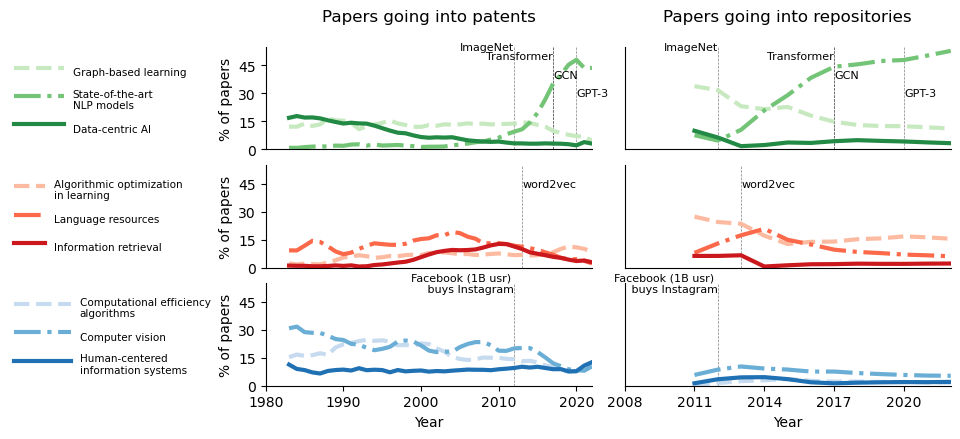

In [47]:
# Drawing plots
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker

def format_y_ticks(y, pos):
    return f"{int(y*100)}"


is_cited = True # <-------- plot the papers associated with patents (repo) or NOT associated
#NUMBER_OF_TOPICS = 9 # <-------- NUMBER OF TOPICS defined previously
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=False, figsize=(7, 3*1.5))

legend_elements = []
j = 0
for dimension in ['innovation', 'development']:

    title = {
        'development': 'repositories',
        'innovation': 'patents'
    }
    if is_cited:
        plot_filter = abs_df[f'is_{dimension}_success'].astype(bool)
        title = f'Papers going into {title[dimension]}\n'
    else:
        plot_filter = ~abs_df[f'is_{dimension}_success'].astype(bool)
        title = f'Papers not going into {title[dimension]}\n'

    table = abs_df[plot_filter].pivot_table(
        index='year',
        columns='topic_id',
        values='corpusid',
        aggfunc='count',
        fill_value=0
    )
    if dimension == "development":
        min_year = 2008
    else:
        min_year = 1980

    table = table.loc[min_year:]

    # Filling up missing topics with zeros
    for col in list(set(np.arange(NUMBER_OF_TOPICS)) - set(table.columns)):
        table[col] = 0

    table.columns = topics
    table_normalized = table.div(table.sum(axis=1), axis=0)

    for i, group in enumerate(GROUPS):

        #table[group].div(table[group].sum(axis=1), axis=0).rolling(window=4).mean().plot.line(ax=axes[i, j])
        window_size = 4 if j <2 else 2
        group_data = table_normalized[group].rolling(window=window_size).mean()
        for idx, column in enumerate(group_data.columns):
            group_name = "group" + str(i)
            line, = axes[i, j].plot(group_data[column].index, group_data[column], 
                                    color=group_palettes[group_name][idx], 
                                    linestyle=group_linestyles[group_name][idx],
                                    label=column, linewidth=3)
            if (dimension, is_cited) == ('innovation', is_cited):
                legend_elements.append(line)

        #
        axes[i, j].legend().set_visible(False)
        if i == 2:
            axes[i, j].set_xlabel('Year')
            axes[i, j].xaxis.set_major_locator(MaxNLocator(nbins=5))
        if i != 2:
            axes[i, j].set_xticks([])
            axes[i, j].set_xlabel('')
        if j == 0:
            label = "% of papers"
            axes[i, j].set_ylabel(label)
            axes[i, j].yaxis.set_major_locator(MaxNLocator(nbins=4))
            y_format = ticker.FuncFormatter(format_y_ticks)
            axes[i, j].yaxis.set_major_formatter(y_format)
        else:
            axes[i, j].set_yticks([])
        if i ==0:
            axes[i, j].set_title(title)
        if j == 2 and i == 1:
            axes[i, j].set_ylim(0, 0.75)
        axes[i, j].set_ylim(0, .55)
        axes[i, 0].set_xlim(1980, 2022)
        axes[i, 1].set_xlim(2008, 2022)


        sns.despine()
        if j == 0:
            if i == 0:
                handlelength = 4.8
            elif i == 1:
                handlelength = 3
            else:
                handlelength = 5.5
            axes[i, 0].legend(handles=legend_elements[i*3:i*3+3], 
                              loc='lower left', ncol=1, fontsize=7.5, 
                              bbox_to_anchor=(-.8, 0),
                              frameon=False,
                              handlelength=handlelength, handleheight=3
            )
    j += 1
# important dates 
def plot_data(i, date, name, align='left', hight=0.5):
    for j in [0, 1]:
        axes[i, j].axvline(date, linestyle='--', color='black', linewidth=.5, zorder=-1, alpha=.5)
        axes[i, j].text(date, hight, name, rotation=0, verticalalignment='center', 
                        horizontalalignment=align, fontsize=8)

plot_data(0, 2012, "ImageNet", 'right', 0.55)
plot_data(0, 2017, "GCN", 'left', 0.4)
plot_data(0, 2017, "Transformer", 'right', 0.5)
plot_data(0, 2020, "GPT-3", 'left', 0.3)
#plot_data(0, 2015, "ResNet", 'left', 0.35)
#plot_data(2, 2010, "Facebook 500M usr", 'left', 0.55)
#plot_data(1, 2010, "Facebook 500M usr", 'left', 0.5)
plot_data(2, 2012, "Facebook (1B usr) \n buys Instagram", 'right', 0.55)
plot_data(1, 2013, "word2vec", 'left', 0.45)

plt.tight_layout()

plt.subplots_adjust(left=0., hspace=0.15, wspace=0.1)
is_appendix = "appendix" if not is_cited else ""
plt.savefig(f'../figures/lda2{is_appendix}.pdf', bbox_inches='tight')